In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import statsmodels.api as sm
import arviz as az

SEED = 100

# Multiple products

In [152]:
np.random.seed(SEED)
M = 25 # products
T = 750
mu_alpha = 2.
sig_alpha = 0.1
alpha = np.random.normal(mu_alpha, sig_alpha,size=M)

mu_decay = -1.5
sig_decay = 0.3
Bdecay = np.random.normal(mu_decay, sig_decay, size=M)

mu_bS = .75
sig_bS = 0.15
bS = np.random.normal(mu_bS, sig_bS, size=M)

sig_mu = 0.025
sig = np.random.normal(sig_mu, 0.001, size=M)

In [153]:
true_effects = {
    "alpha":alpha,
    "decay":Bdecay,
    "bS":bS,
    "AR":sig
}

In [154]:
np.random.seed(SEED)

t = np.arange(1, T+1)
seasonality = np.where( t//(365/2) % 2 == 0, 1, 0)
wave = (np.sin(t/(365/6.3))+1)/2
ar = np.random.normal(0, sig,size=(T,M)).cumsum(0)
mu = alpha[:,None] + ar.T + Bdecay[:,None]*(t/365) + bS[:,None]*wave
y_mu = np.exp(mu).T
y = np.random.poisson(y_mu)

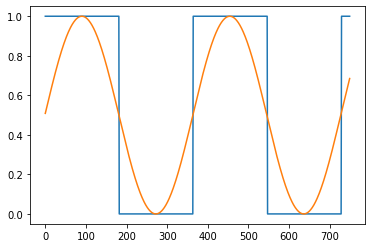

In [155]:
plt.plot(seasonality)
plt.plot( wave )

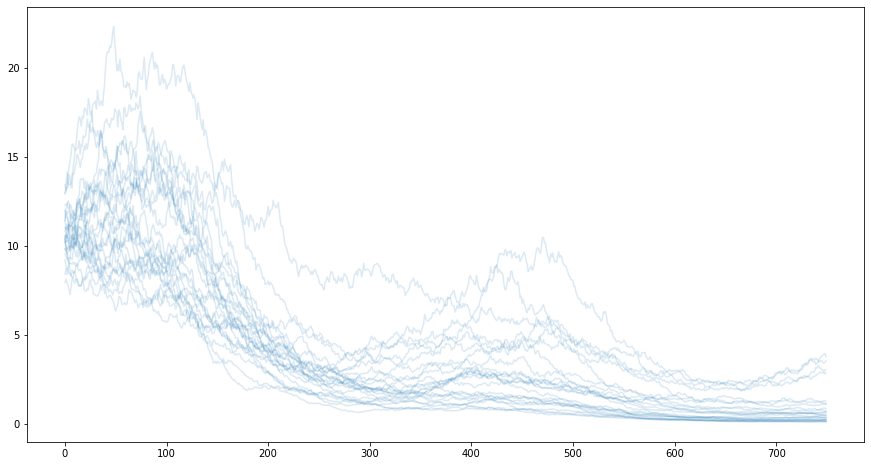

In [156]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(y_mu, alpha=0.15, color="C0");
# ax.plot(y, alpha=0.15, color="C0");

# Bayesian Model

In [157]:
import pymc3 as pm

In [158]:
df = pd.DataFrame({
    "style":np.repeat([f"P{i}" for i in range(M)], T),
    "t":np.tile(t, M),
    "season":np.tile(wave,M),
    "y":y.T.ravel()
}).assign(y_tminus1 = lambda d: d.groupby("style").y.shift(1).bfill())

df

,style,t,season,y,y_tminus1
0,P0,1,0.508630,12,12.0
1,P0,2,0.517257,7,12.0
2,P0,3,0.525879,5,7.0
3,P0,4,0.534493,5,5.0
4,P0,5,0.543097,9,5.0
...,...,...,...,...,...
18745,P24,746,0.652431,0,4.0
18746,P24,747,0.660627,6,0.0
18747,P24,748,0.668776,2,6.0
18748,P24,749,0.676874,4,2.0


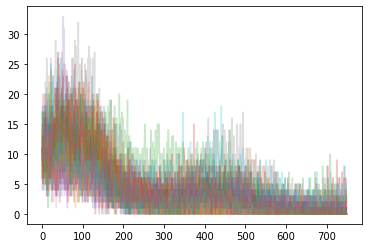

In [159]:
gpby = df.set_index(["style", "t"]).groupby("style")["y"]
gpby.plot(use_index=False,alpha=0.25);

In [28]:
s_, s_labels = pd.factorize(df["style"])

coords={"style":s_labels}
with pm.Model(coords=coords) as m:
    alpha = pm.Normal("alpha", 2, 0.5, dims="style")
    bS = pm.Normal("bS", 0.75, .15, dims="style")
    gamma = pm.Normal("gamma", -1.5, 0.35, dims="style")
    bAR = pm.Normal("bAR", 0.025, 0.001)
    
    mu = pm.Deterministic("mu", alpha[s_] + bS[s_]*df.season.values + gamma[s_]*df.t.values/365 + bAR*df.y_tminus1 )
    lambd = pm.Deterministic("lambd", pm.math.exp(mu))
    rentals = pm.Poisson("rentals", lambd, observed=df.y.values)
    

### Prior Predictive Simulation

In [29]:
with m:
    prior_pred = pm.sample_prior_predictive()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_52932/4269814647.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_52932/4269814647.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_52932/4269814647.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


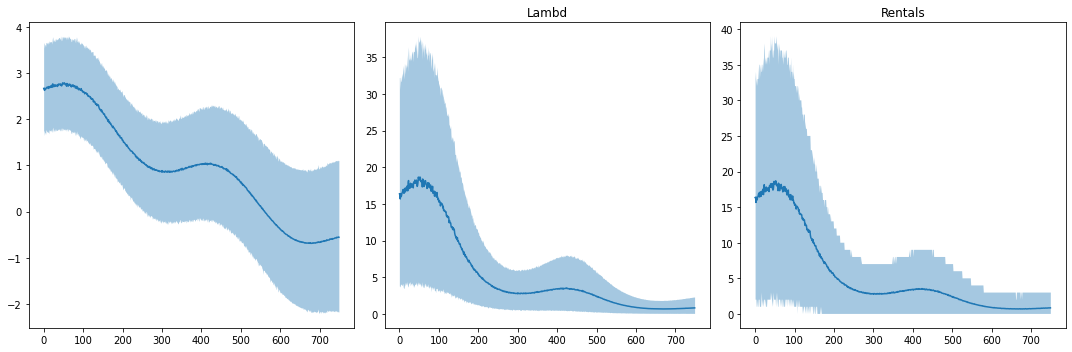

In [30]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[1].set_title("mu")
arr = prior_pred["mu"].reshape(500*M, (T))
bounds = az.hdi(arr)
ax[0].plot(arr.mean(0))
ax[0].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[1].set_title("Lambd")
arr = prior_pred["lambd"].reshape(500*M, (T))
bounds = az.hdi(arr)
ax[1].plot(arr.mean(0))
ax[1].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[2].set_title("Rentals")
arr = prior_pred["rentals"].reshape(500*M, (T))
bounds = az.hdi(arr)
ax[2].plot(arr.mean(0))
ax[2].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)
plt.tight_layout()

In [31]:
with m:
    trace = pm.sample(init="advi+adapt_diag", 
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 33800
Interrupted at 33,799 [16%]: Average Loss = 5.3279e+29
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bAR, gamma, bS, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.


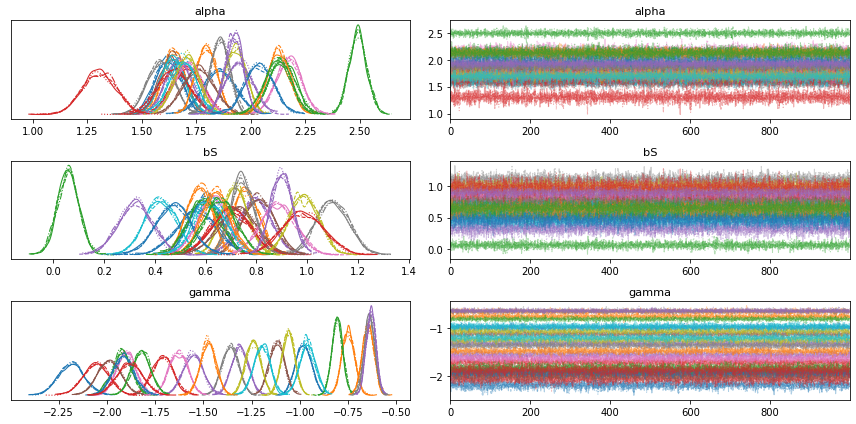

In [32]:
pm.plot_trace(trace, var_names=["alpha", "bS", "gamma"])
plt.tight_layout()

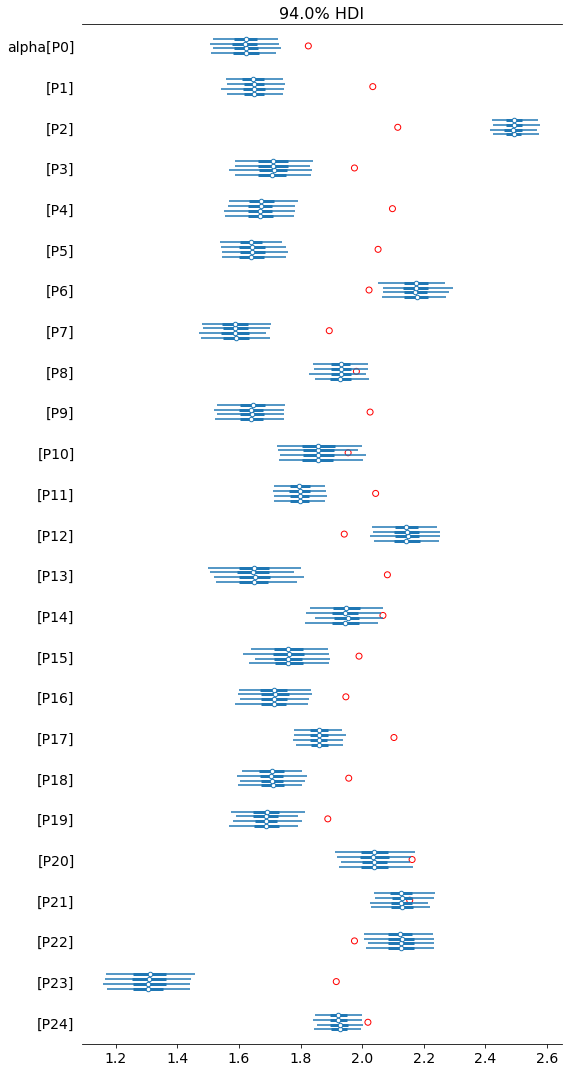

In [33]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["alpha"], ax=ax )
ax.scatter( true_effects["alpha"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

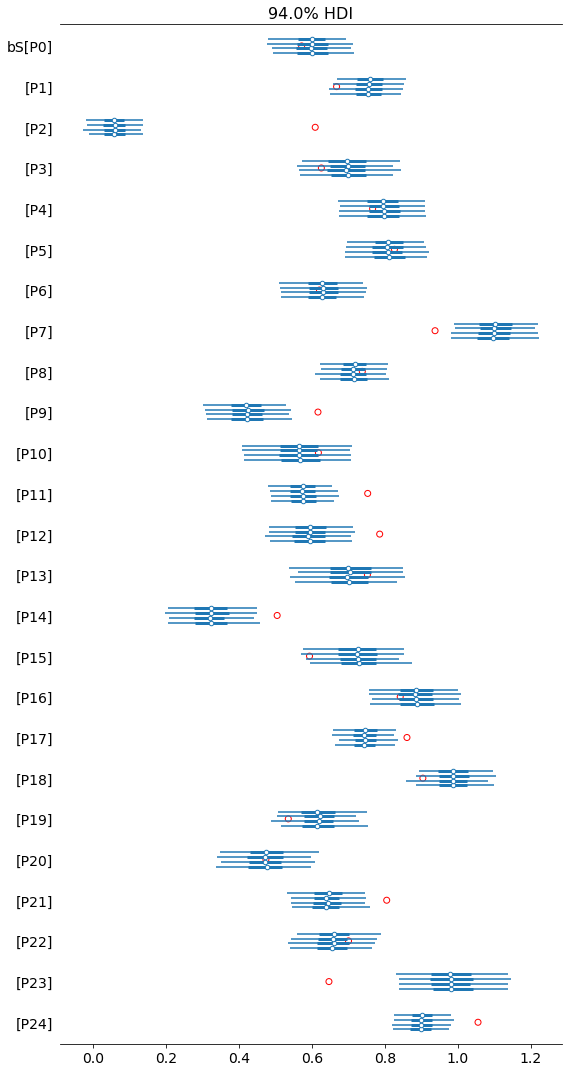

In [34]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["bS"], ax=ax )
ax.scatter( true_effects["bS"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

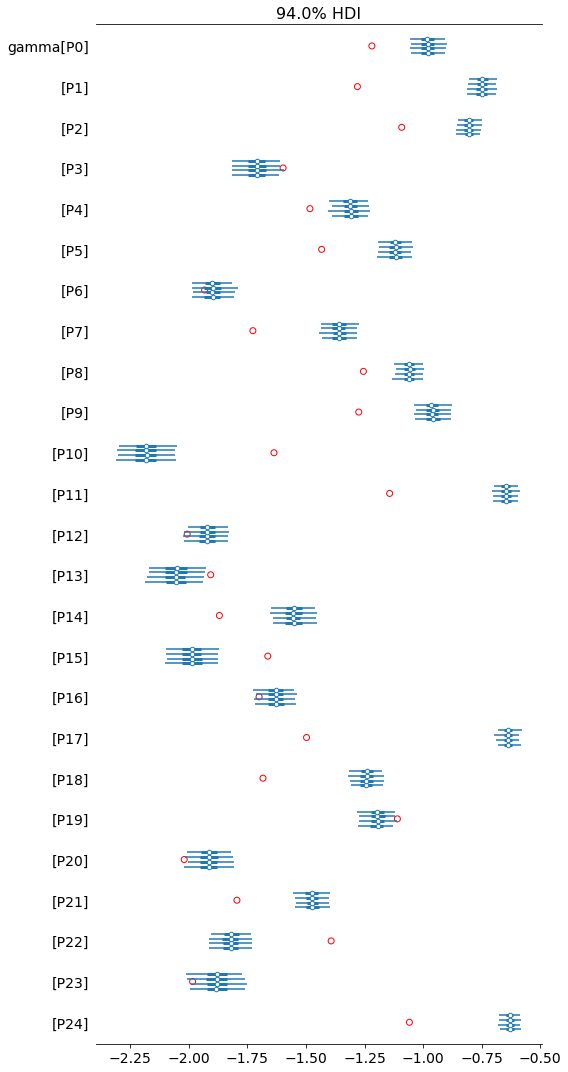

In [35]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["gamma"], ax=ax )
ax.scatter( true_effects["decay"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

# Hierarchical Model

In [36]:
def hierarchical_normal(name, dims, μ=0.):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 0.001, dims=dims)
    σ = pm.Exponential('σ_{}'.format(name), 0.1)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [37]:
with pm.Model(coords=coords) as m2:
    mu_alpha = pm.Normal("mu_alpha", 2, 0.5)
    alpha = hierarchical_normal("alpha", dims="style", μ=mu_alpha)
    
    mu_bS = pm.Normal("mu_bS", 0.75, .2)
    bS = hierarchical_normal("bS", dims="style", μ=mu_bS)

    mu_gamma = pm.Normal("mu_gamma", -5, 1.5)
    gamma = hierarchical_normal("gamma", dims="style", μ=mu_gamma)

    bAR = pm.Normal("bAR", 0.05, 0.001)
    
    mu = pm.Deterministic("mu", alpha[s_] + bS[s_]*df.season.values + gamma[s_]*df.t.values/1000 + bAR*df.y_tminus1 )
    lambd = pm.Deterministic("lambd", pm.math.exp(mu))
    rentals = pm.Poisson("rentals", lambd, observed=df.y)
    

### Prior predictive

In [111]:
nsamples=1000
with m2:
    prior_pred = pm.sample_prior_predictive(nsamples)

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_52932/1399281028.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_52932/1399281028.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_52932/1399281028.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


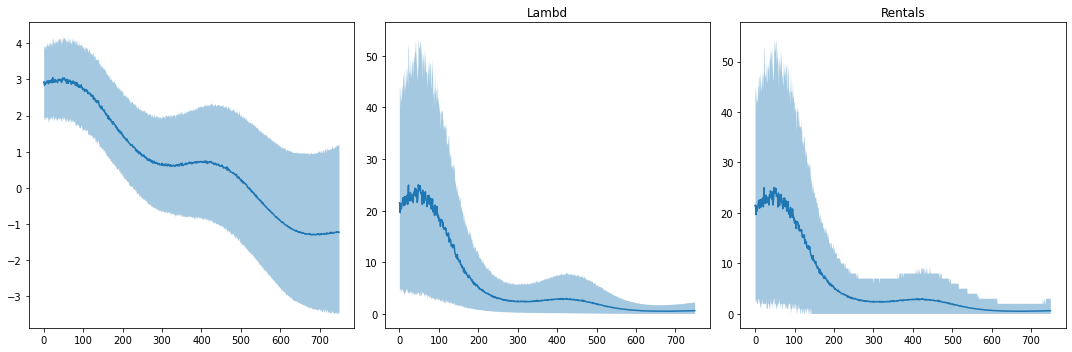

In [112]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[1].set_title("mu")
arr = prior_pred["mu"].reshape(nsamples*M, T)
bounds = az.hdi(arr)
ax[0].plot(arr.mean(0))
ax[0].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[1].set_title("Lambd")
arr = prior_pred["lambd"].reshape(nsamples*M, T)
bounds = az.hdi(arr)
ax[1].plot(arr.mean(0))
ax[1].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)

ax[2].set_title("Rentals")
arr = prior_pred["rentals"].reshape(nsamples*M, T)
bounds = az.hdi(arr)
ax[2].plot(arr.mean(0))
ax[2].fill_between(np.arange(1,T+1), bounds[:,0], bounds[:,1], alpha=0.4)
plt.tight_layout()

### Fit Model

In [113]:
with m2:
    trace2 = pm.sample(init="advi+adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 62200
Interrupted at 62,199 [31%]: Average Loss = 8.8519e+50
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bAR, σ_gamma, Δ_gamma, mu_gamma, σ_bS, Δ_bS, mu_bS, σ_alpha, Δ_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 187 seconds.
The number of effective samples is smaller than 25% for some parameters.


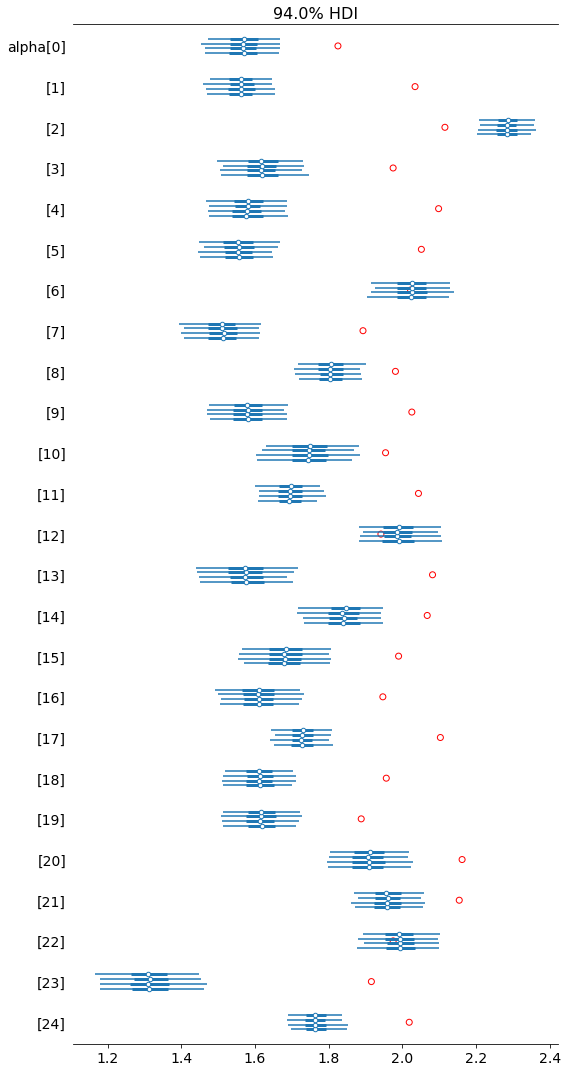

In [114]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["alpha"], ax=ax )
ax.scatter( true_effects["alpha"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

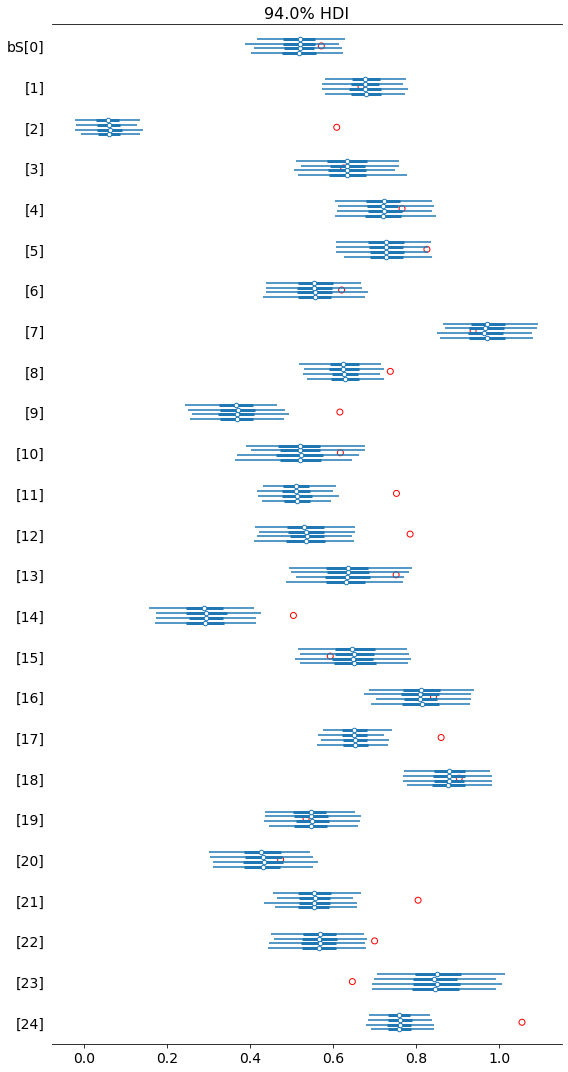

In [115]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["bS"], ax=ax )
ax.scatter( true_effects["bS"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

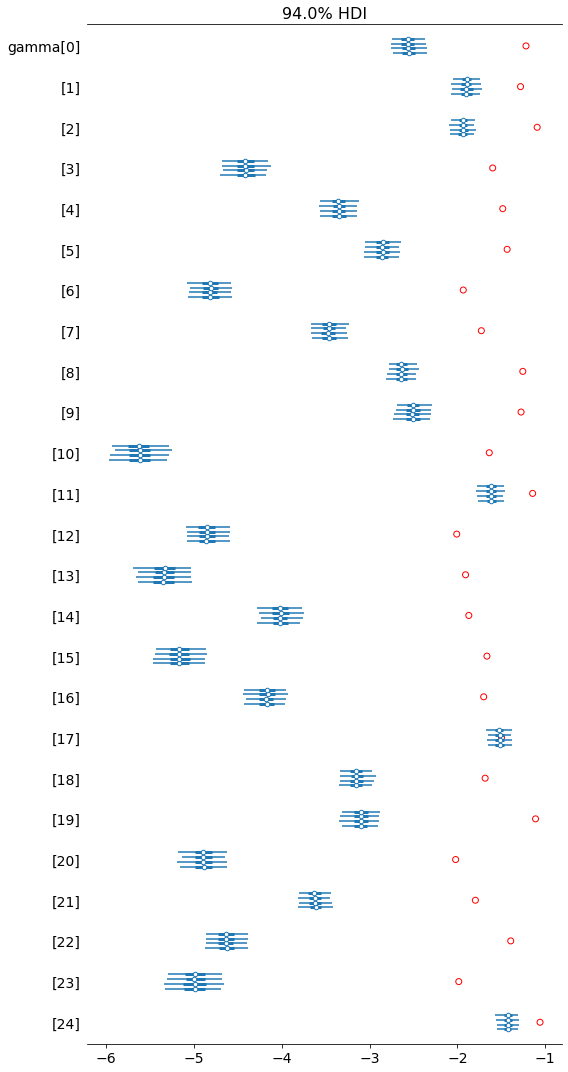

In [120]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["gamma"], ax=ax )
ax.scatter( true_effects["decay"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

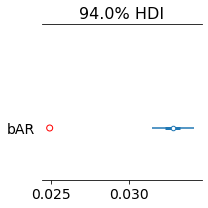

In [117]:
fig ,ax = plt.subplots(1,1,figsize=(3, 3))
pm.plot_forest( trace2, var_names=["bAR"], ax=ax, combined=True )
ax.scatter( true_effects["AR"].mean(), ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

In [118]:
with m2:
    preds = pm.sample_posterior_predictive(trace2)

In [125]:
yhat = preds["rentals"].reshape(4000, -1, T)


/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_52932/1066006978.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


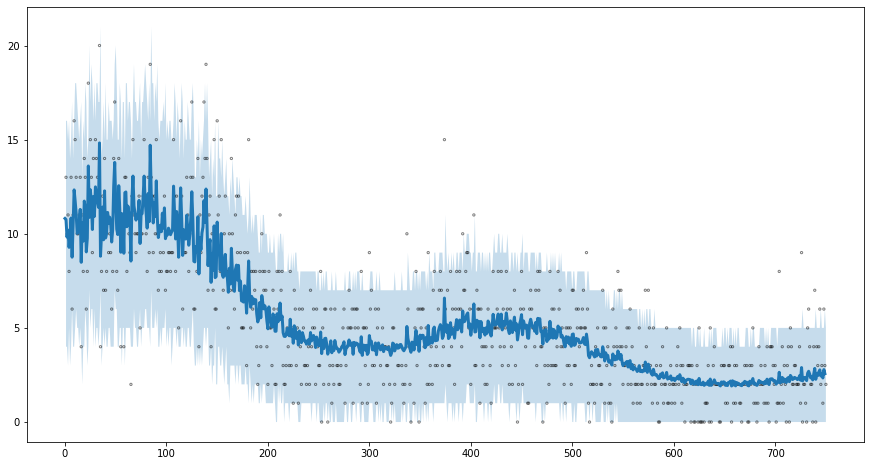

In [143]:


idx = np.random.choice(M)
arr = yhat[:,idx,:]
bounds = az.hdi(arr)

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(arr.mean(0), lw=3)
ax.fill_between(t, bounds[:,0], bounds[:,1], alpha=0.25)
ax.scatter(t, df.loc[lambda d: d["style"]==f"P{idx}"].y, 
            edgecolor="k",facecolor="none", alpha=0.5, s=5)